In [1]:
# The code was removed by DSX for sharing.

In [2]:
import requests, StringIO, json

def get_file_content(credentials):
    """For given credentials, this functions returns a StringIO object containg the file content 
    from the associated Bluemix Object Storage V3."""

    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                if(e2['interface']=='public'and e2['region']==credentials['region']):
                    url2 = ''.join([e2['url'],'/', credentials['container'], '/', credentials['filename']])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO.StringIO(resp2.content)

In [3]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

# load the dataset
dataframe = pandas.read_csv(get_file_content(credentials_1), usecols=[4], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    
# reshape dataset
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(2, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=5, batch_size=32)

# Estimate model performance
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

Using TensorFlow backend.


Epoch 1/5
20975/20975 [==============================] - 0s - loss: 157328.8280     
Epoch 2/5
20975/20975 [==============================] - 0s - loss: 37.8097     
Epoch 3/5
20975/20975 [==============================] - 0s - loss: 26.9196     
Epoch 4/5
20975/20975 [==============================] - 0s - loss: 26.9418     
Epoch 5/5
20975/20975 [==============================] - 0s - loss: 26.9067     
Train Score: 26.84 MSE (5.18 RMSE)
Test Score: 15027.61 MSE (122.59 RMSE)


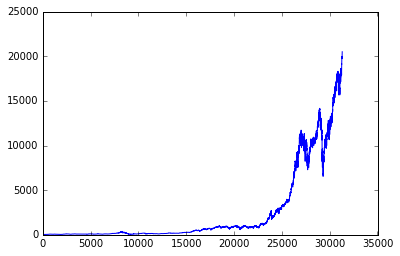

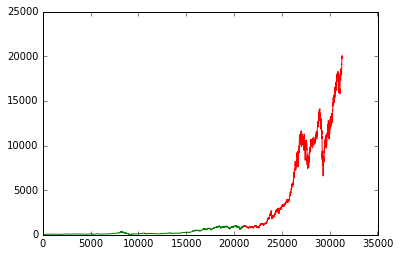

In [4]:
plt.plot(dataset)
plt.show()
plt.plot(trainPredictPlot,'g')
plt.plot(testPredictPlot,'r')
plt.show()